In [1]:
import os
import sys

root_folder = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_folder)

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
%matplotlib widget

from dynamics.freeflyer import FreeflyerModel, ocp_no_obstacle_avoidance, ocp_obstacle_avoidance, check_koz_constraint
from optimization.ff_scenario import n_obs, n_time_rpod, obs, table, robot_radius, safety_margin, dt, T
import decision_transformer.manage as DT_manager
from dynamics.FreeflyerEnv import FreeflyerEnv
import time
from decision_transformer.art_closed_loop import AutonomousFreeflyerTransformerMPC, ConvexMPC

/home/davide.celestini/Transformer/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu


In [16]:
# Simulation configuration
transformer_model_name = 'checkpoint_ff_ctgrtg_art_cl_4' #'checkpoint_rtn_v11'/'checkpoint_rtn_v01'
transformer_config = DT_manager.transformer_import_config(transformer_model_name)
mdp_constr = transformer_config['mdp_constr']
timestep_norm = transformer_config['timestep_norm']
transformer_ws = 'dyn'
datasets, dataloaders = DT_manager.get_train_val_test_data(mdp_constr=mdp_constr, timestep_norm=timestep_norm)
train_dataset, val_dataset, test_dataset = datasets
train_loader, eval_loader, test_loader = dataloaders

Loading data from root/dataset/torch/...Completed, DATA IS NOT SHUFFLED YET.



In [ ]:
import torch
state_init = np.array([0.2,0.15,0,0,0,0])#np.array([0.22, 2.14, 1.53, 0, 0, 0])#np.array([1.58643470e-01,  5.06685234e-01, -1.07279630e+00, 0.0,0.0,0.0])#
state_final = np.array([3.2,2.3,np.pi,0,0,0])#np.array([3.31, 0.60, -1.28, 0, 0, 0])#np.array([3.25586406,  2.29016048, -0.80894559, 0.0, 0.0, 0.0])#
test_sample = next(iter(test_loader))
data_stats = test_loader.dataset.data_stats
test_sample[0][0,:,:] = (torch.tensor(np.repeat(state_init[None,:], 100, axis=0)) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#(torch.tensor(xs[:-1,:]) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#
test_sample[1][0,:,:] = torch.zeros((100,3))#(torch.tensor(us) - data_stats['actions_mean'])/(data_stats['actions_std'] + 1e-6)#
test_sample[2][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_reward_to_go(test_sample[1][0,:,:]))#
test_sample[3][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_constraint_to_go(test_sample[0][0,:,:].cpu().numpy(), obs_positions, obs_radii))#
test_sample[4][0,:,:] = (torch.tensor(np.repeat(state_final[None,:], 100, axis=0)) - data_stats['goal_mean'])/(data_stats['goal_std'] + 1e-6)


In [17]:
select_idx = True # set to True to manually select a test trajectory via its index (idx)
idx = 11787 # index of the test trajectory 19030, 11787, 5514->infeasible in cvxMPC at 4 timestep 32172
# Sample from test dataset
if select_idx:
    test_sample = test_loader.dataset.getix(idx)
else:
    test_sample = next(iter(test_loader))
if mdp_constr:
    states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, dt, time_sec, ix = test_sample
else:
    states_i, actions_i, rtgs_i, goal_i, timesteps_i, attention_mask_i, dt, time_sec, ix = test_sample
print('Sampled trajectory ' + str(ix) + ' from test_dataset.')
data_stats = test_loader.dataset.data_stats
state_init = ((test_sample[0][0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])).cpu().numpy()
state_final = ((test_sample[4][0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])).cpu().numpy()

# FreeFlyerModel
ffm = FreeflyerModel(verbose=True)
dt = dt.item()
time_sec = np.hstack((time_sec[0,0], time_sec[0,0,-1] + dt))

Sampled trajectory [11787] from test_dataset.
Initializing freeflyer class.


CVX cost: 0.21998551303175473
SCP cost: 0.35484896348462475
J vect [4.11666250e-01 3.58583736e-01 3.55054584e-01 3.54849570e-01
 3.54848963e-01 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]
GPT size: 11.1M parameters
Using ART model ' checkpoint_ff_ctgrtg_art_cl_4 ' with inference function DT_manage.torch_model_inference_dyn()
ART cost: 0.2986093
ART runtime: 0.5297939777374268
SCP cost: 0.2905046857617387
J vect [2.90511356e-01 2.90504697e-01 2.90504686e-01 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]


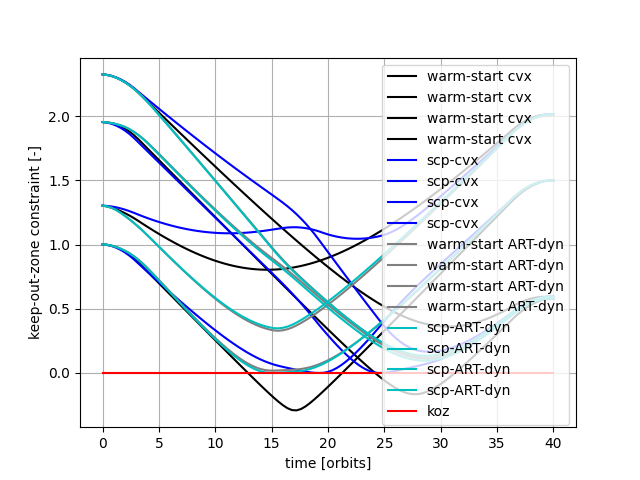

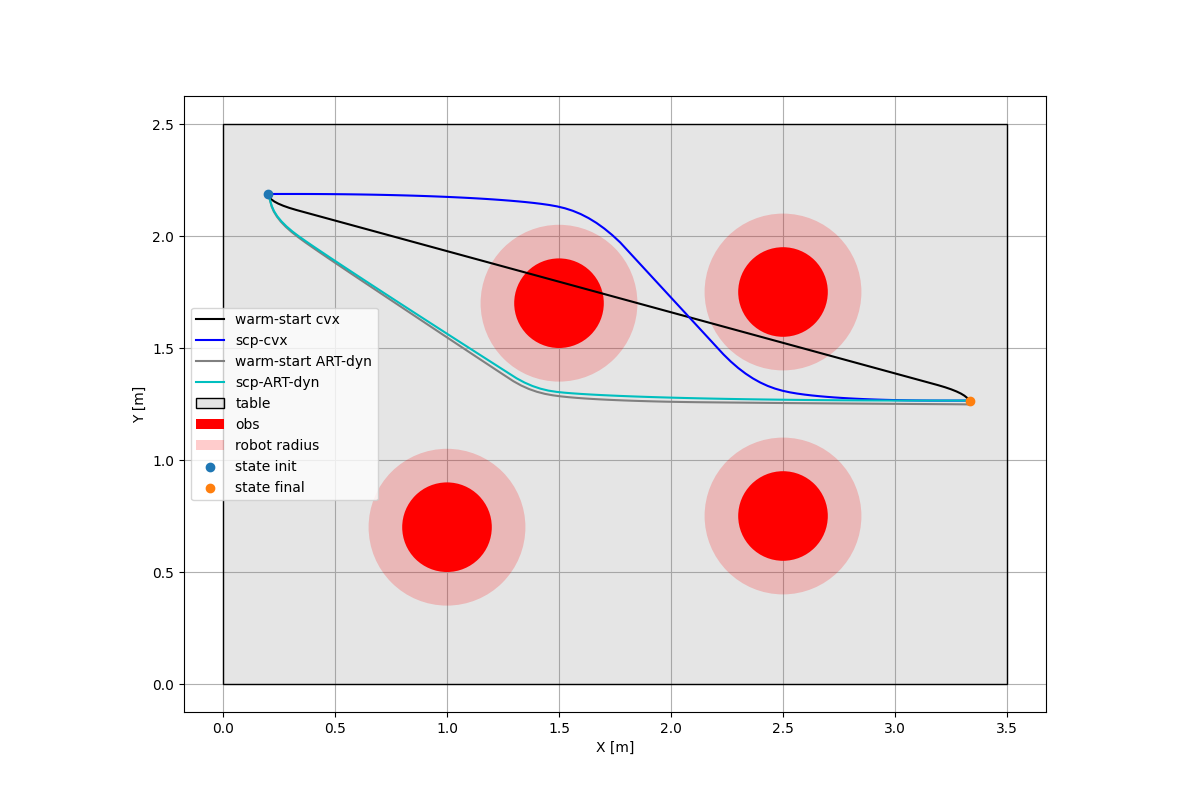

In [18]:
# Warmstarting and optimization
# Obstacles info
obs_positions = obs['position']
obs_radii = (obs['radius'] + robot_radius)*safety_margin
# Solve Convex Problem
traj_cvx, _, n_iter_cvx, feas_cvx = ocp_no_obstacle_avoidance(ffm, state_init, state_final)
states_ws_cvx, actions_ws_cvx = traj_cvx['states'], traj_cvx['actions_G']
print('CVX cost:', np.sum(la.norm(actions_ws_cvx, ord=1, axis=0)))
constr_cvx, constr_viol_cvx= check_koz_constraint(states_ws_cvx.T, obs_positions, obs_radii)
# Solve SCP
traj_scp_cvx, J_vect_scp_cvx, iter_scp_cvx, feas_scp_cvx = ocp_obstacle_avoidance(ffm, states_ws_cvx+np.array([0,0.,0,0,0,0]).reshape(-1,1), actions_ws_cvx, state_init, state_final)
states_scp_cvx, actions_scp_cvx = traj_scp_cvx['states'], traj_scp_cvx['actions_G']
print('SCP cost:', np.sum(la.norm(actions_scp_cvx, ord=1, axis=0)))
print('J vect', J_vect_scp_cvx)
constr_scp_cvx, constr_viol_scp_cvx = check_koz_constraint(states_scp_cvx.T, obs_positions, obs_radii)

# Import the Transformer
model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader)
model.eval()
inference_func = getattr(DT_manager, 'torch_model_inference_'+transformer_ws)
print('Using ART model \'', transformer_model_name, '\' with inference function DT_manage.'+inference_func.__name__+'()')
rtg = - np.sum(la.norm(actions_ws_cvx, ord=1, axis=0)) if mdp_constr else None #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
DT_trajectory, runtime_DT = inference_func(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg, ctg_clipped=True)
states_ws_DT = np.append(DT_trajectory['xypsi_' + transformer_ws], (DT_trajectory['xypsi_' + transformer_ws][:,-1] + ffm.B_imp @ DT_trajectory['dv_' + transformer_ws][:, -1]).reshape((6,1)), 1)# set warm start
actions_ws_DT = DT_trajectory['dv_' + transformer_ws]
print('ART cost:', np.sum(la.norm(actions_ws_DT, ord=1, axis=0)))
print('ART runtime:', runtime_DT)
constr_DT, constr_viol_DT = check_koz_constraint(states_ws_DT.T, obs_positions, obs_radii)

# Solve SCP
traj_scp_DT, J_vect_scp_DT, iter_scp_DT, feas_scp_DT = ocp_obstacle_avoidance(ffm, states_ws_DT, actions_ws_DT, state_init, state_final)
states_scp_DT, actions_scp_DT = traj_scp_DT['states'], traj_scp_DT['actions_G']
print('SCP cost:', np.sum(la.norm(actions_scp_DT, ord=1, axis=0)))
print('J vect', J_vect_scp_DT)
constr_scp_DT, constr_viol_scp_DT = check_koz_constraint(states_scp_DT.T, obs_positions, obs_radii)

# Plotting

# 3D position trajectory
ax = plt.figure(figsize=(12,8)).add_subplot()
p1 = ax.plot(states_ws_cvx[0,:], states_ws_cvx[1,:], 'k', linewidth=1.5, label='warm-start cvx', zorder=3)
p2 = ax.plot(states_scp_cvx[0,:], states_scp_cvx[1,:], 'b', linewidth=1.5, label='scp-cvx', zorder=3)
p3 = ax.plot(states_ws_DT[0,:], states_ws_DT[1,:], c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws, zorder=3)
p4 = ax.plot(states_scp_DT[0,:], states_scp_DT[1,:], 'c', linewidth=1.5, label='scp-ART-' + transformer_ws, zorder=3)
ax.add_patch(Rectangle((0,0), table['xy_up'][0], table['xy_up'][1], fc=(0.5,0.5,0.5,0.2), ec='k', label='table', zorder=2.5))
for n_obs in range(obs['radius'].shape[0]):
    label_obs = 'obs' if n_obs == 0 else None
    label_robot = 'robot radius' if n_obs == 0 else None
    ax.add_patch(Circle(obs['position'][n_obs,:], obs['radius'][n_obs], fc='r', label=label_obs, zorder=2.5))
    ax.add_patch(Circle(obs['position'][n_obs,:], obs['radius'][n_obs]+robot_radius, fc='r', alpha=0.2, label=label_robot, zorder=2.5))
ax.scatter(state_init[0], state_init[1], label='state init', zorder=3)
ax.scatter(state_final[0], state_final[1], label='state final', zorder=3)
ax.grid(True)
ax.set_aspect('equal')
ax.set_xlabel('X [m]', fontsize=10)
ax.set_ylabel('Y [m]', fontsize=10)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
#plt.savefig(root_folder + '/optimization/saved_files/plots/pos_3d.png')

# Constraint satisfaction
plt.figure()
plt.plot(time_sec, constr_cvx.T, 'k', linewidth=1.5, label='warm-start cvx')
plt.plot(time_sec, constr_scp_cvx.T, 'b', linewidth=1.5, label='scp-cvx')
plt.plot(time_sec, constr_DT.T, c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_sec, constr_scp_DT.T, 'c', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_sec, np.zeros(n_time_rpod+1), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)
#plt.savefig(root_folder + '/optimization/saved_files/plots/constr.png')

plt.show()

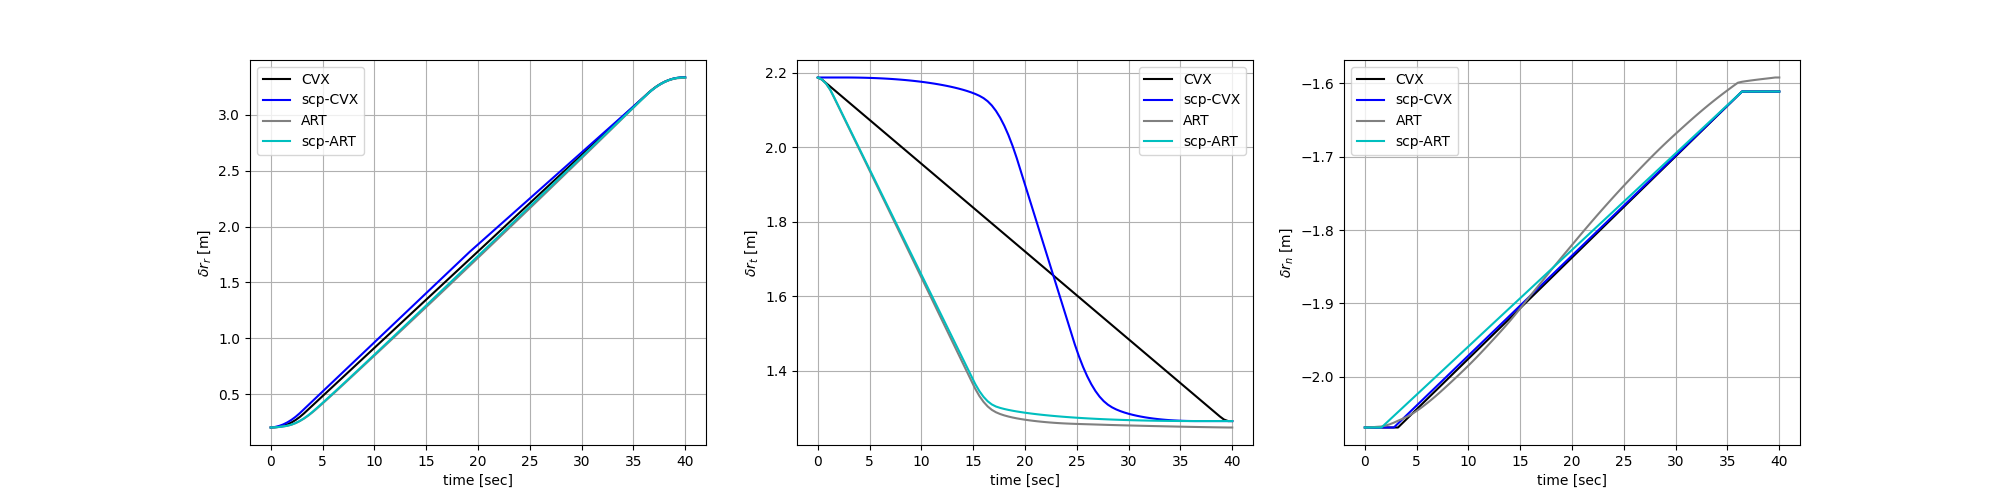

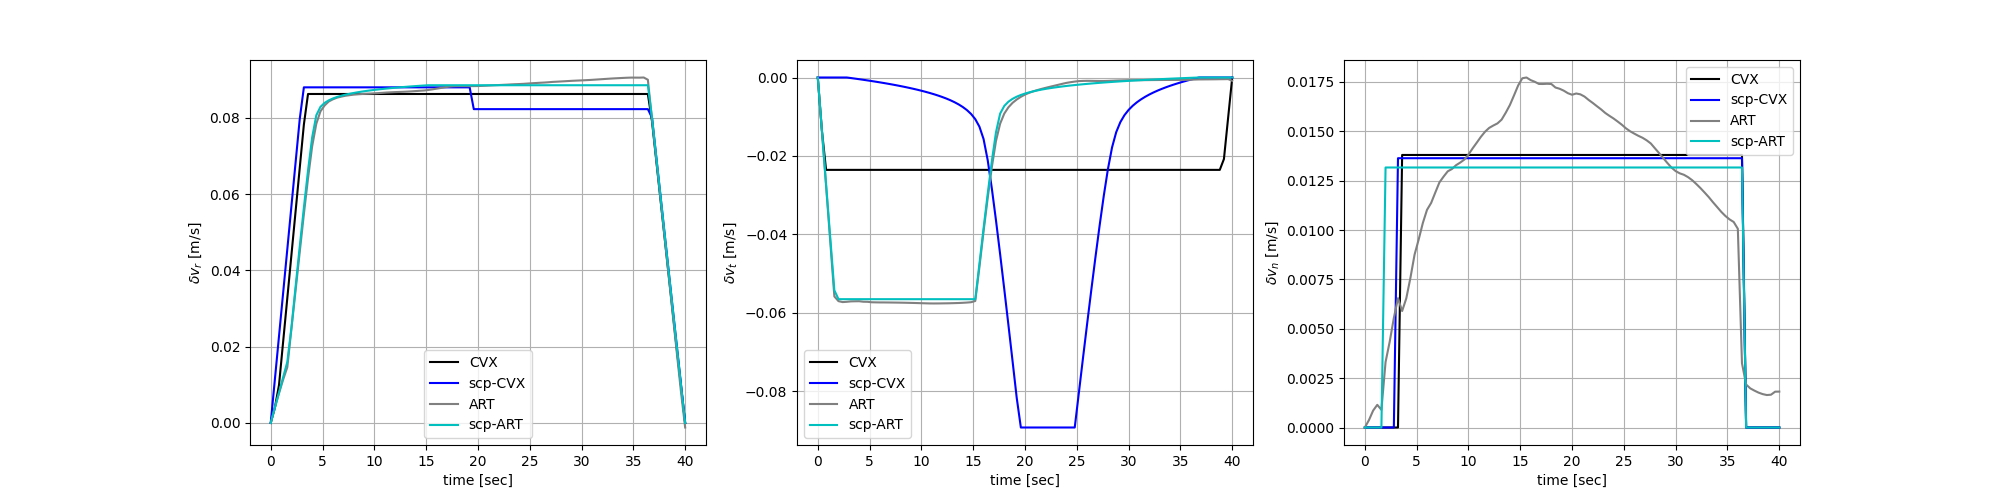

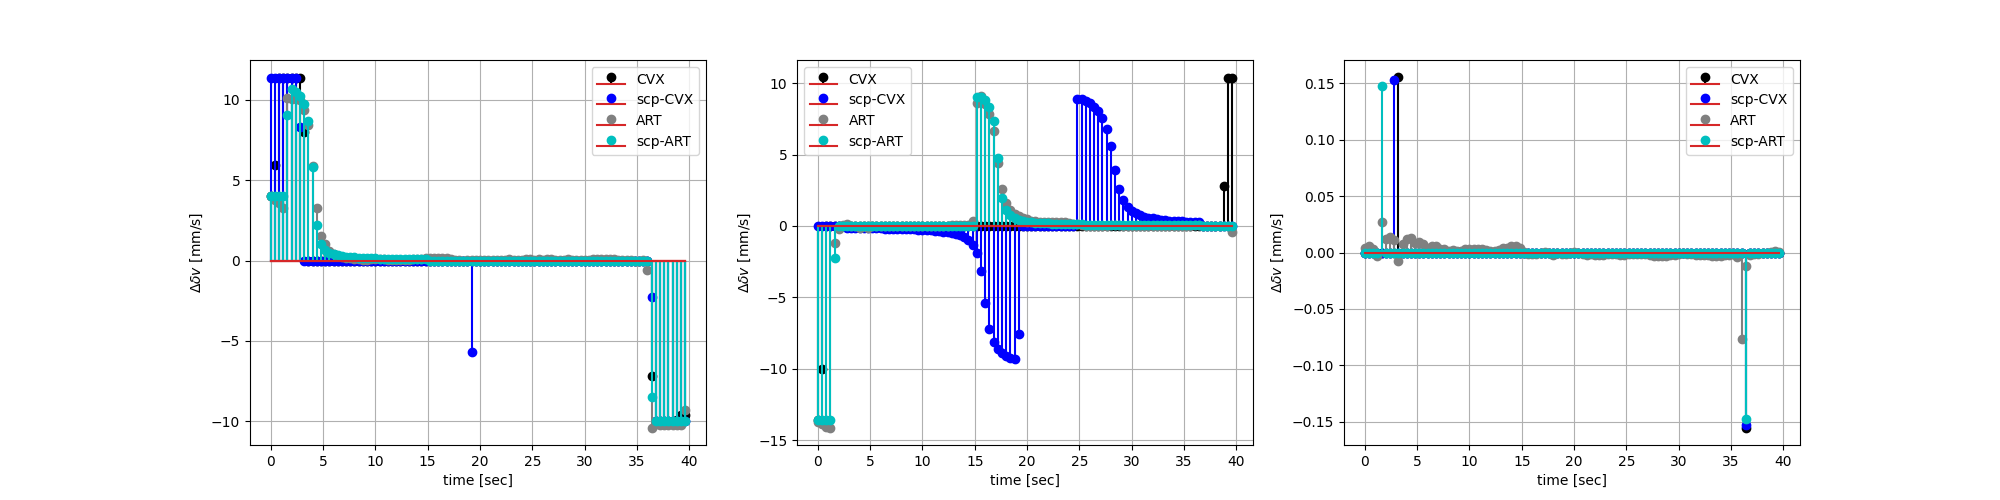

In [19]:
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_sec, states_ws_cvx[j,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_sec, states_scp_cvx[j,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_sec, states_ws_DT[j,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_sec, states_scp_DT[j,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_sec, states_ws_cvx[j+3,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_sec, states_scp_cvx[j+3,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_sec, states_ws_DT[j+3,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_sec, states_scp_DT[j+3,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()
###### DELTA-V

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time_sec[:-1], actions_ws_cvx[j,:]*1000., linefmt='k', markerfmt='ko', label='CVX')
    plt.stem(time_sec[:-1], actions_scp_cvx[j,:]*1000, linefmt='b', markerfmt='bo', label='scp-CVX')
    plt.stem(time_sec[:-1], actions_ws_DT[j,:]*1000., linefmt='grey', markerfmt='o', label='ART')
    plt.stem(time_sec[:-1], actions_scp_DT[j,:]*1000, linefmt='c', markerfmt='o', label='scp-ART')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [20]:
quad_env_art = FreeflyerEnv(PID=False)
quad_env_cvx = FreeflyerEnv(PID=False)
traj_sample = (dt, state_init, state_final)
quad_env_art.reset('det',traj_sample)
quad_env_cvx.reset('det',traj_sample)
aft_cl = AutonomousFreeflyerTransformerMPC(model,test_loader,10,transformer_mode='dyn',ctg_clipped=True,scp_mode='soft')
'''oracle_cl = ConvexMPC(100,scp_mode='soft')'''
cvx_cl = ConvexMPC(10,scp_mode='soft')#AutonomousFreeflyerTransformerMPC(model,test_loader,70,transformer_mode='dyn',ctg_clipped=True,scp_mode='soft')#
'''art_cl = IterativeSequentialConvexProgrammingMPC('art', model, test_loader,scp_mode='soft')
cvx_cl = IterativeSequentialConvexProgrammingMPC('cvx',scp_mode='soft')
cvx_cl = MyopicConvexMPC(100,scp_mode='soft')
cvx_cl = TwoPointsBoundaryValueProblemMPC(100,scp_mode='soft')'''

"art_cl = IterativeSequentialConvexProgrammingMPC('art', model, test_loader,scp_mode='soft')\ncvx_cl = IterativeSequentialConvexProgrammingMPC('cvx',scp_mode='soft')\ncvx_cl = MyopicConvexMPC(100,scp_mode='soft')\ncvx_cl = TwoPointsBoundaryValueProblemMPC(100,scp_mode='soft')"

In [21]:
time_ARTMPC = np.empty((actions_ws_DT.shape[1],))
time_CVXMPC = np.empty((actions_ws_DT.shape[1],))
time_myo_CVXMPC = np.empty((actions_ws_DT.shape[1],))
flag = 'art'

for i in np.arange(actions_ws_DT.shape[1]):
    print(i)
    if flag == 'art' or flag == 'all':
        # ART-ws
        current_obs_art = quad_env_art.get_observation()
        tic = time.time()
        if mdp_constr:
            ART_traj = aft_cl.warmstart(current_obs_art, quad_env_art, rtg0=rtg, ctg0=0)
        else:
            ART_traj = aft_cl.warmstart(current_obs_art, quad_env_art, rtgs_i=rtgs_i)
        ARTMPC_traj, ARTMPC_scp_dict = aft_cl.solve_scp(current_obs_art, quad_env_art, ART_traj['state'], ART_traj['dv'])
        time_ARTMPC[i] = time.time() - tic
        '''print('oracle')
        oracle_traj, stm, cim, psi = oracle_cl.warmstart(current_obs_art, rpod_env_art, return_dynamics=True)
        oracleMPC_traj, oracleMPC_scp_dict = oracle_cl.solve_scp(current_obs_art, rpod_env_art, stm, cim, psi, oracle_traj['state_roe'], oracle_traj['dv_rtn'])'''
        quad_env_art.load_prediction(ART_traj, ARTMPC_traj)
        _ = quad_env_art.step(action=ARTMPC_traj['dv'][:,0], state_desired=ARTMPC_traj['state'][:,1])
    
    if flag == 'cvx' or flag == 'all':
        #CVX-ws
        current_obs_cvx = quad_env_cvx.get_observation()
        tic = time.time()
        CVX_traj = cvx_cl.warmstart(current_obs_cvx, quad_env_cvx, rtg0=rtg, ctg0=0)
        CVXMPC_traj, CVXMPC_scp_dict = cvx_cl.solve_scp(current_obs_cvx, quad_env_cvx, CVX_traj['state'], CVX_traj['dv'])
        if CVXMPC_scp_dict['feas'] == 'infeasible':
            CVX_traj['state'] = quad_env_cvx.pred_history[-1]['state_ARTMPC'][:,1:]
            CVX_traj['dv'] = quad_env_cvx.pred_history[-1]['dv_ARTMPC'][:,1:]
            CVXMPC_traj, CVXMPC_scp_dict = cvx_cl.solve_scp(current_obs_cvx, quad_env_cvx, CVX_traj['state'], CVX_traj['dv'])
        time_CVXMPC[i] = time.time() - tic
        quad_env_cvx.load_prediction(CVX_traj, CVXMPC_traj)
        _ = quad_env_cvx.step(action=CVXMPC_traj['dv'][:,0], state_desired=CVXMPC_traj['state'][:,1])


0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IndexError: index 1 is out of bounds for axis 1 with size 1

interactive(children=(IntSlider(value=0, description='k', max=101), Output()), _dom_classes=('widget-interact'…

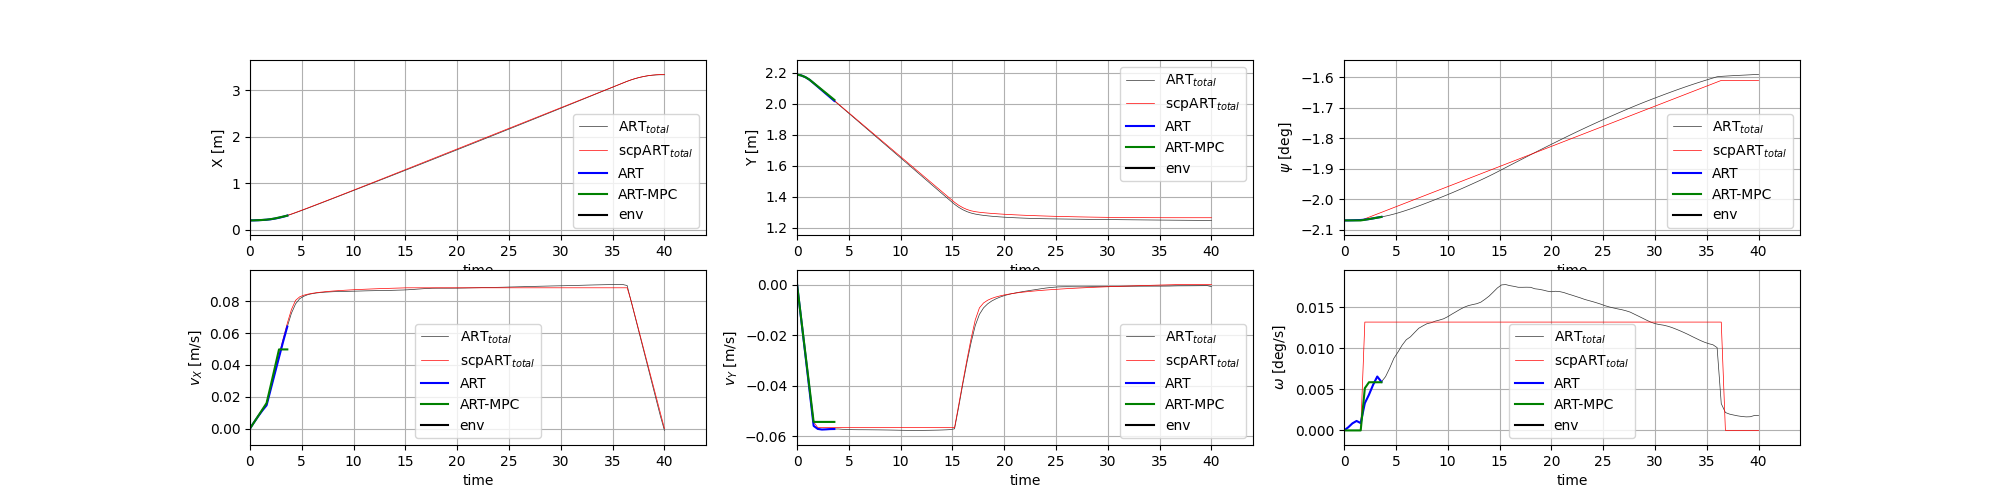

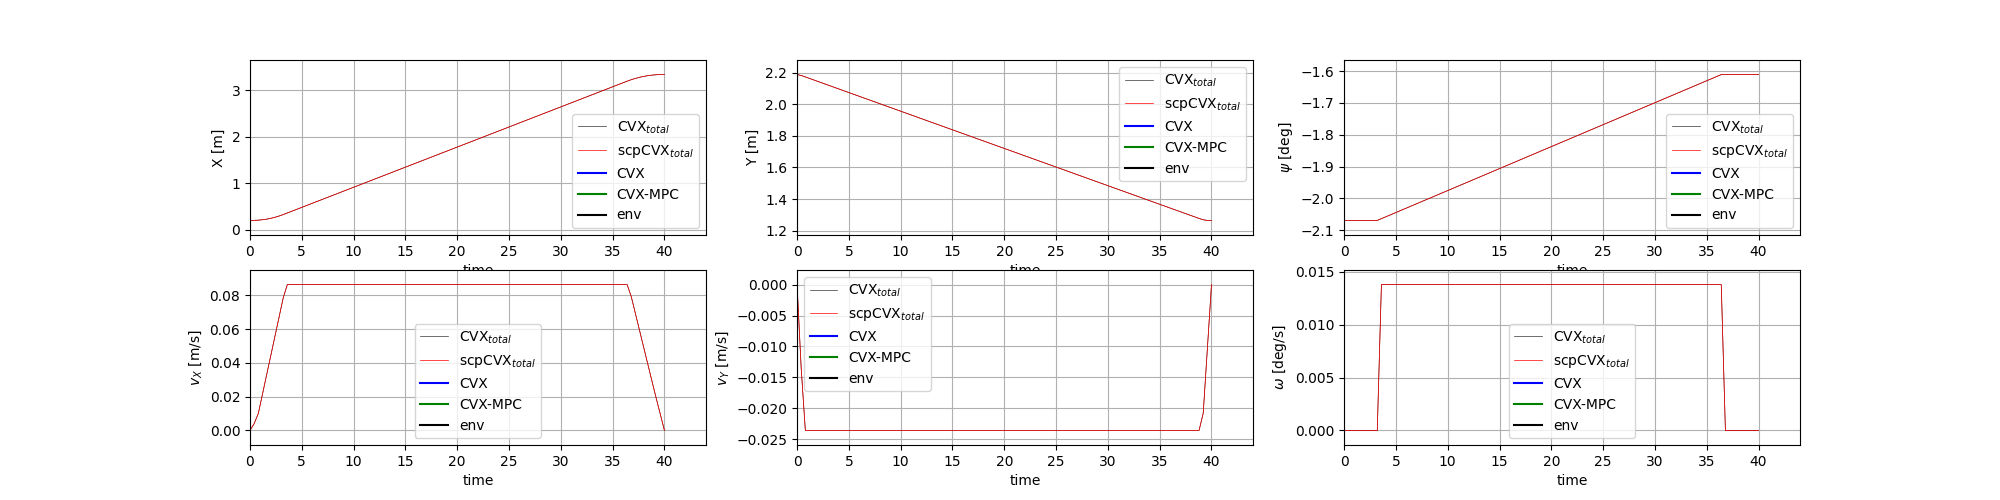

In [22]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_ART' : states_ws_DT,
    'state_scpART' : states_scp_DT,
    'time' : time_sec
}
fig_art, ax_art = quad_env_art.plot(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_ws_cvx,#states_scp_cvx,
    'time' : time_sec
}
fig_cvx, ax_cvx = quad_env_cvx.plot(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state' : quad_env_art.state[:,:k+1],
            'time' : quad_env_art.time[:k+1]
        }
        quad_env_art.plot(ax=ax_art, plan=(quad_env_art.pred_history[k] if k < quad_env_art.timestep else None), history=history_dict_art)
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state' : quad_env_cvx.state[:,:k+1],
            'time' : quad_env_cvx.time[:k+1]
        }
        quad_env_cvx.plot(ax=ax_cvx, plan=(quad_env_cvx.pred_history[k] if k < quad_env_cvx.timestep else None), history=history_dict_cvx)
        fig_cvx.canvas.draw()

    #return fig_art

/home/davide.celestini/ff_ws/src/freeflyer2/ff_control/transformer_controller/dynamics/FreeflyerEnv.py:404: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))


interactive(children=(IntSlider(value=0, description='k', max=101), Output()), _dom_classes=('widget-interact'…

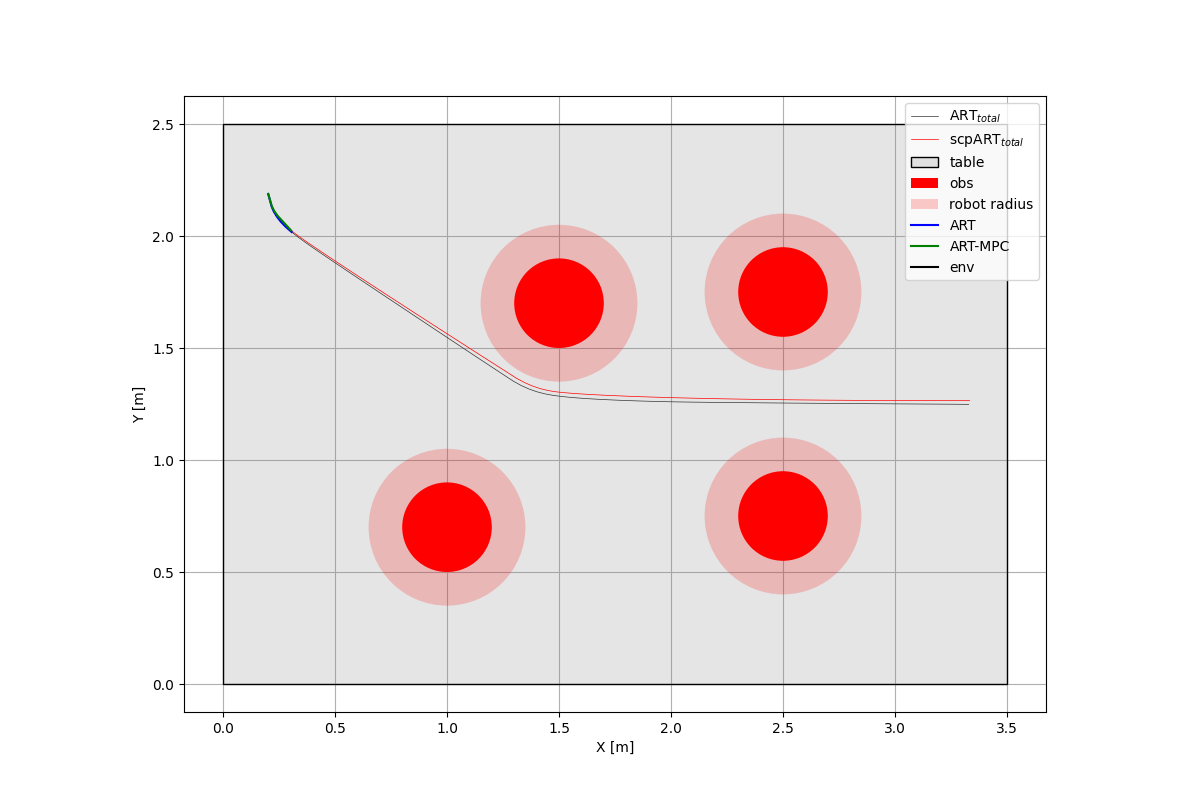

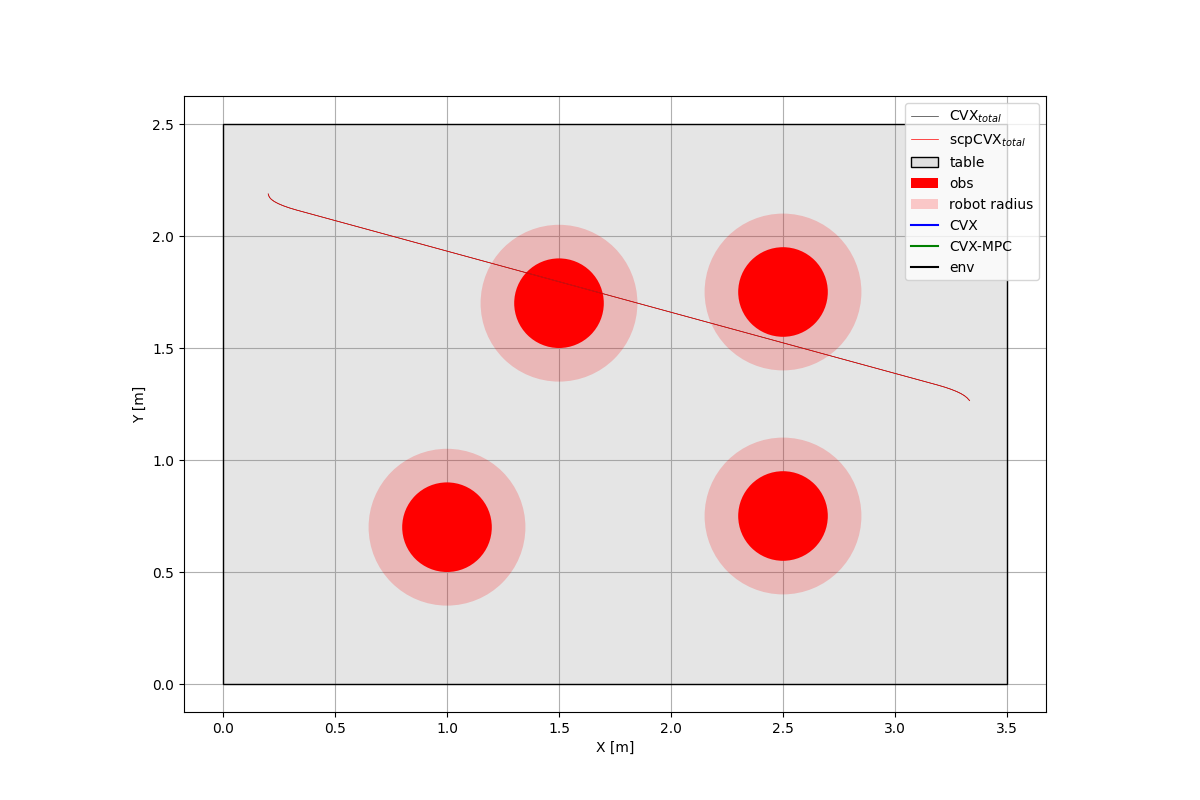

In [23]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_ART' : states_ws_DT,
    'state_scpART' : states_scp_DT,
    'time' : time_sec
}
fig_art, ax_art = quad_env_art.plot3D(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_ws_cvx,#states_scp_cvx,
    'time' : time_sec
}
fig_cvx, ax_cvx = quad_env_cvx.plot3D(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

flag = 'all'
@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state' : quad_env_art.state[:,:k+1],
            'time' : quad_env_art.time[:k+1]
        }
        quad_env_art.plot3D(ax=ax_art, plan=(quad_env_art.pred_history[k] if k < quad_env_art.timestep else None), history=history_dict_art)
        ax_art.set_aspect('equal')
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state' : quad_env_cvx.state[:,:k+1],
            'time' : quad_env_cvx.time[:k+1]
        }
        quad_env_cvx.plot3D(ax=ax_cvx, plan=(quad_env_cvx.pred_history[k] if k < quad_env_cvx.timestep else None), history=history_dict_cvx)
        ax_cvx.set_aspect('equal')
        fig_cvx.canvas.draw()

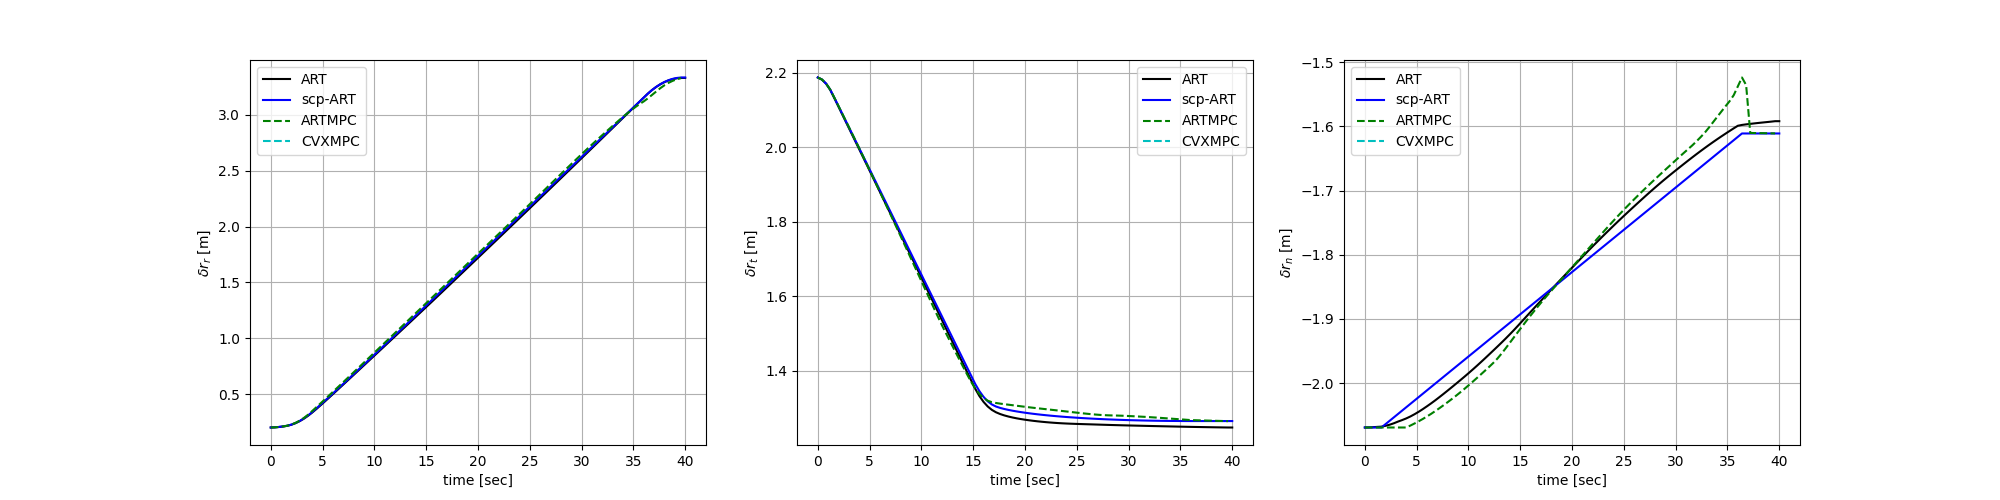

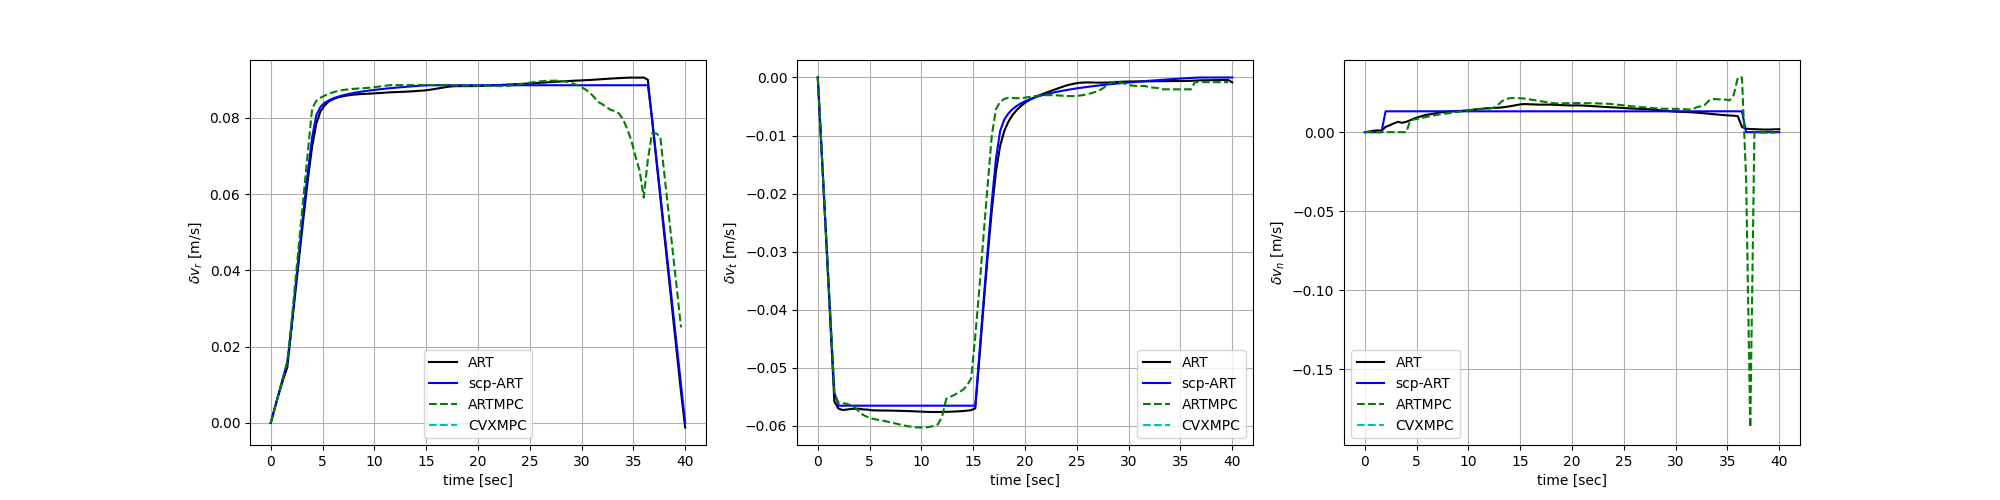

In [24]:
# Timeseries to compare
time0 = time_sec#ART_traj['time_orb'][0]#
states0 = states_ws_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time1 = time_sec#ART_traj['time_orb'][0]#
states1 = states_scp_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time2 = quad_env_art.time#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states2 = quad_env_art.state#np.empty((6,0))#ARTMPC_traj['state_rtn']#ART_traj['state_rtn']#
time3 = quad_env_cvx.time#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states3 = quad_env_cvx.state#np.empty((6,0))#ART_traj['state_rtn']#ARTMPC_traj['state_rtn']#

plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j+3,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j+3,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j+3,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j+3,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

ValueError: could not broadcast input array from shape (0,) into shape (99,)

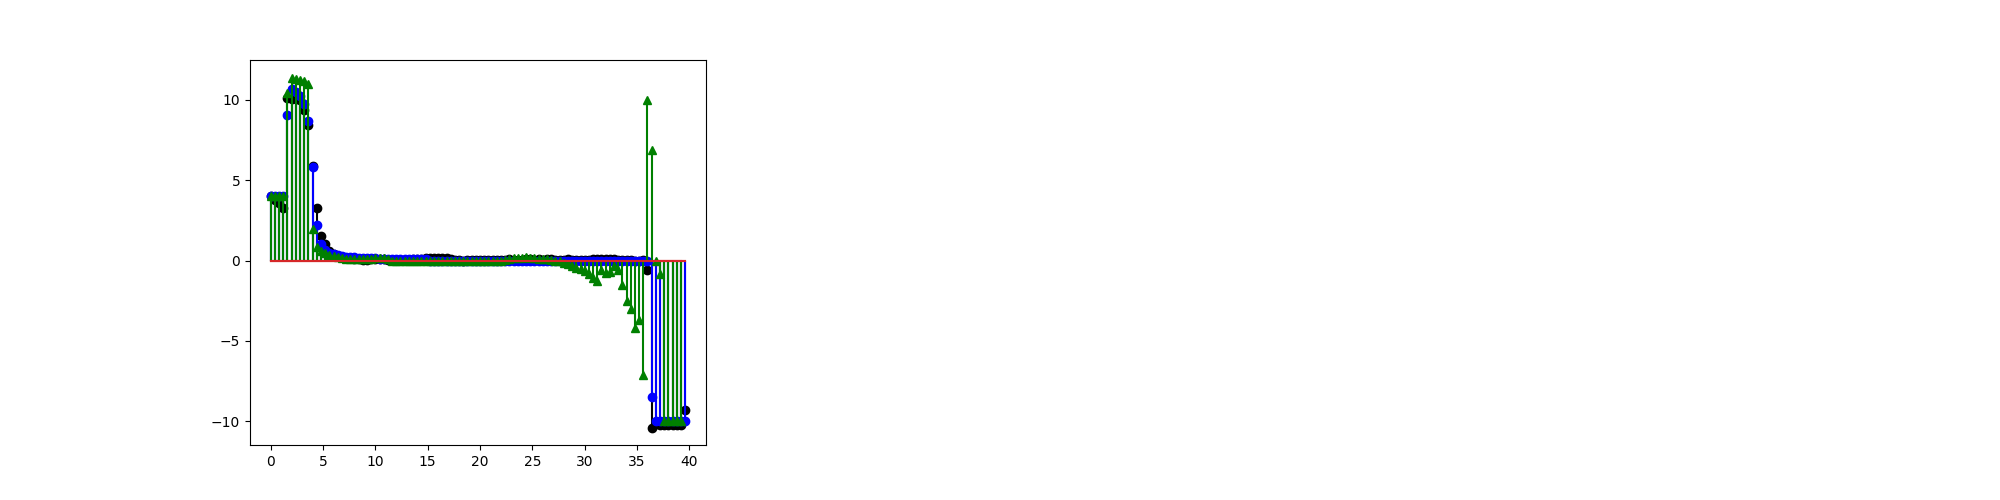

In [25]:
###### DELTA-V
# Timeseries to compare
time0 = time_sec[:-1]#ART_traj['time_orb'][0]#
action0 = actions_ws_DT#ARTMPC_dv_rtn#
time1 = time_sec[:-1]#ART_traj['time_orb'][0]#
action1 = actions_scp_DT#ARTMPC_dv_rtn#
time2 = quad_env_art.time[:-1]#time_orb[0][:-1]#ART_traj['time_orb']#
action2 = quad_env_art.dv#ART_traj['dv_rtn']#
time3 = quad_env_art.time[:-1]#time_orb[0][:-1]#ART_traj['time_orb']#
action3 = quad_env_cvx.dv#ART_traj['dv_rtn']#

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time0, action0[j,:]*1000., linefmt='k', markerfmt='ko', label='ART')
    plt.stem(time1, action1[j,:]*1000., linefmt='b', markerfmt='bo', label='scp-ART')
    plt.stem(time2, action2[j,:]*1000, linefmt='g', markerfmt='g^', label='ARTMPC')
    plt.stem(time3, action3[j,:]*1000, linefmt='c', markerfmt='c*', label='CVXMPC')
    
    if j == 0:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_r$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_t$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [sec]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_n$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
constr_ARTMPC, constr_viol_ARTMPC = check_koz_constraint(quad_env_art.state.T, quad_env_art.obs['position'], (quad_env_art.obs['radius'] + quad_env_art.robot_radius)*quad_env_art.safety_margin)
constr_CVXMPC, constr_viol_CVXMPC = check_koz_constraint(quad_env_cvx.state.T, quad_env_art.obs['position'], (quad_env_art.obs['radius'] + quad_env_art.robot_radius)*quad_env_art.safety_margin)

# Constraint satisfaction
plt.figure()
plt.plot(time_sec, constr_DT.T, 'k', linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_sec, constr_scp_DT.T, 'b', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_sec, constr_ARTMPC.T, 'g--', linewidth=1.5, label='ART-MPC')
plt.plot(time_sec, constr_CVXMPC.T, 'c--', linewidth=1.5, label='CVX-MPC')
plt.plot(time_sec, np.zeros(n_time_rpod+1), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)

In [ ]:
np.sum(np.linalg.norm(actions_scp_DT,axis=0)**2)/2

In [26]:
print('ART-MPC cost', np.sum(np.linalg.norm(quad_env_art.dv,axis=0,ord=1)))
print('CVX-MPC cost', np.sum(np.linalg.norm(quad_env_cvx.dv,axis=0,ord=1)))
print('SCP open loop cost history', J_vect_scp_DT)

ART-MPC cost 0.31671479182125434
CVX-MPC cost 0.0
SCP open loop cost history [2.90511356e-01 2.90504697e-01 2.90504686e-01 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]


In [ ]:
plt.figure()
plt.plot(time_ARTMPC, label='ARTMPC')
plt.plot(time_CVXMPC, label='CVXMPC')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
results = np.load('saved_files/closed_loop_analysis_checkpoint_rtn_ctgrtg_v02.npz')
results.allow_pickle = True
cost = results['cost'].item()
indexes = results['indexes']
count_eff = results['counter_eff']


## Experimental stuff

In [ ]:
current_obs_cvx = quad_env_cvx.get_observation()
CVX_traj = cvx_cl.warmstart(current_obs_cvx, quad_env_cvx)

In [ ]:
prec_state = quad_env_cvx.pred_history[-1]['state_ARTMPC'][:,1:]
prec_action = quad_env_cvx.pred_history[-1]['dv_ARTMPC'][:,1:]
CVX_traj['state'] = prec_state
CVX_traj['dv'] = prec_action

In [ ]:
# Initial state and constraints extraction from the current environment
t_i = quad_env_cvx.timestep
t_f = min(t_i + cvx_cl.n_steps, quad_env_cvx.n_time_rpod)
n_time = t_f - t_i
# Extract real state from environment observation
current_state = current_obs_cvx['state']
current_goal = current_obs_cvx['goal']

# Makse sure the inputs have the correct dimensions (n_steps, n_state) and (n_steps, n_actions)
states_ref = CVX_traj['state'].T
state_end_ref = states_ref[-1,:]
actions_ref = CVX_traj['dv'].T
J_vect = np.ones(shape=(cvx_cl.iter_max_SCP,), dtype=float)*1e12

# Initial condition for the scp
DELTA_J = 10
trust_region = cvx_cl.trust_region0
beta_SCP = (cvx_cl.trust_regionf/cvx_cl.trust_region0)**(1/cvx_cl.iter_max_SCP)

In [ ]:
import copy
import cvxpy as cp
import optimization.ff_scenario as ff
def ocp_scp_closed_loop(state_ref, action_ref, state_init, state_final, state_end_ref, t_i, t_f, env:FreeflyerEnv, trust_region, scp_mode, obs_av=True):
    # IMPORTANT: state_ref and action_ref are the references and must be of shape (n_steps,n_state) and (n_steps,n_actions)
    # Setup SQP problem
    state_ref, action_ref = state_ref.T, action_ref.T
    n_time = state_ref.shape[1]
    ffm = env.ff_model
    obs = copy.deepcopy(env.obs)
    obs['radius'] = (obs['radius'] + env.robot_radius)*env.safety_margin
    print('obs_position: ', obs['position'])
    print('obs_radius: ', obs['radius'])
    s = cp.Variable((6, n_time))
    a = cp.Variable((3, n_time))

    if scp_mode == 'hard':
        # CONSTRAINTS
        constraints = []

        # Initial, dynamics and final state
        constraints += [s[:,0] == state_init]
        constraints += [s[:,k+1] == ffm.Ak @ (s[:,k] + ffm.B_imp @ a[:,k]) for k in range(n_time-1)]
        if t_f == env.n_time_rpod:
            constraints += [(s[:,-1] + ffm.B_imp @ a[:,-1]) == state_final]
        # Table extension
        constraints += [s[:2,:] >= ff.start_region['xy_low'][:,None]]
        constraints += [s[:2,:] <= ff.goal_region['xy_up'][:,None]]
        # Trust region and koz and action bounding box
        for k in range(0,n_time):
            # Trust region
            b_soc_k = -state_ref[:,k]
            constraints += [cp.SOC(trust_region, s[:,k] + b_soc_k)]
            # keep-out-zone
            if k > 0 and obs_av:
                for n_obs in range(len(obs['radius'])):
                    c_koz_k = np.transpose(state_ref[:2,k] - obs['position'][n_obs,:]).dot(np.eye(2)/((obs['radius'][n_obs])**2))
                    b_koz_k = np.sqrt(c_koz_k.dot(state_ref[:2,k] - obs['position'][n_obs,:]))
                    constraints += [c_koz_k @ (s[:2,k] - obs['position'][n_obs,:]) >= b_koz_k]
            # action bounding box
            A_bb_k, B_bb_k = ffm.action_bounding_box_lin(state_ref[2,k], action_ref[:,k])
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] >= -ffm.Dv_t_M]
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] <= ffm.Dv_t_M]
        
        # Cost function
        rho = 1.
        cost = cp.sum(cp.norm(a, 1, axis=0))
        if t_f < env.n_time_rpod:
            cost = cost + rho*cp.norm(s[:,-1] - state_end_ref, 2)

    else:
        # CONSTRAINTS
        constraints = []
        # Initial, dynamics and final state
        constraints += [s[:,0] == state_init]
        constraints += [s[:,k+1] == ffm.Ak @ (s[:,k] + ffm.B_imp @ a[:,k]) for k in range(n_time-1)]
        # Table extension
        constraints += [s[:2,:] >= ff.start_region['xy_low'][:,None]]
        constraints += [s[:2,:] <= ff.goal_region['xy_up'][:,None]]
        # Trust region and koz and action bounding box
        for k in range(0,n_time):
            # Trust region
            b_soc_k = -state_ref[:,k]
            constraints += [cp.SOC(trust_region, s[:,k] + b_soc_k)]
            # keep-out-zone
            if k > 0 and obs_av:
                for n_obs in range(len(obs['radius'])):
                    c_koz_k = np.transpose(state_ref[:2,k] - obs['position'][n_obs,:]).dot(np.eye(2)/((obs['radius'][n_obs])**2))
                    b_koz_k = np.sqrt(c_koz_k.dot(state_ref[:2,k] - obs['position'][n_obs,:]))
                    constraints += [c_koz_k @ (s[:2,k] - obs['position'][n_obs,:]) >= b_koz_k]
            # action bounding box
            A_bb_k, B_bb_k = ffm.action_bounding_box_lin(state_ref[2,k], action_ref[:,k])
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] >= -ffm.Dv_t_M]
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] <= ffm.Dv_t_M]
        
        # Compute Cost
        rho = 1.
        cost = cp.sum(cp.norm(a, 1, axis=0))
        # Goal reaching penalizing term: if the end of the maneuver is already in the planning horizon aim for the goal
        if t_f == env.n_time_rpod:
            cost = cost + 10*cp.norm((s[:,-1] + ffm.B_imp @ a[:,-1]) - state_final, 2)
        
        # Otherwise follow the warmstarting reference
        else:
            cost = cost + rho*cp.norm(s[:,-1] - state_end_ref, 2)
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    
    # SolveOSQP problem
    prob.solve(solver=cp.ECOS, verbose=False)

    if prob.status == 'infeasible':
        print("[solve]: Problem infeasible.")
        s_opt = None
        a_opt = None
        J = None
    else:
        s_opt = s.value.T
        a_opt = a.value.T
        J = prob.value

    return s_opt, a_opt, J, prob.status


In [ ]:
for scp_iter in range(cvx_cl.iter_max_SCP):
    '''print("scp_iter =", scp_iter)'''
    # Solve OCP (safe)
    try:
        states, actions, cost, feas = ocp_scp_closed_loop(states_ref, actions_ref, current_state, current_goal, state_end_ref, t_i, t_f, quad_env_cvx, trust_region, cvx_cl.scp_mode)
    except:
        states = None
        actions = None
        feas = 'infeasible'
    if np.char.equal(feas,'infeasible'):
        try:
            print('cvxMPC failed')
            states, actions, cost, feas = ocp_scp_closed_loop(prec_state, prec_action, current_state, current_goal, state_end_ref, t_i, t_f, quad_env_cvx, trust_region, cvx_cl.scp_mode)
        except:
            states = None
            actions = None
            feas = 'infeasible'
    
    if not np.char.equal(feas,'infeasible'):
        J_vect[scp_iter] = cost
        # compute error
        trust_error = np.max(np.linalg.norm(states - states_ref, axis=0))
        if scp_iter > 0:
            DELTA_J = cost_prev - cost

        # Update iterations
        states_ref = states
        actions_ref = actions
        cost_prev = cost
        trust_region = beta_SCP*trust_region
        if scp_iter >= 1 and (trust_error <= cvx_cl.trust_regionf and abs(DELTA_J) < cvx_cl.J_tol):
            break
    else:
        print(feas)
        print('unfeasible scp') 
        break

In [ ]:
CVXMPC_traj

In [ ]:
CVXMPC_traj = {
    'state' : states.T if not np.char.equal(feas,'infeasible') else None,
    'dv' : actions.T if not np.char.equal(feas,'infeasible') else None
}

In [ ]:
quad_env_cvx.load_prediction(CVX_traj, CVXMPC_traj)

In [ ]:
quad_env_cvx.pred_history[-1]

In [ ]:
_ = quad_env_cvx.step(CVXMPC_traj['dv'][:,0])
len(quad_env_cvx.pred_history)

In [ ]:
maneuver_dict_cvx = {
    'state_ART' : states_ws_cvx,
    'state_scpART' : states_scp_cvx,
    'time' : time_sec
}
k=38
fig_cvx, ax_cvx = quad_env_cvx.plot3D(maneuver=maneuver_dict_cvx, mpc_label='CVX')
history_dict_cvx = {
    'state' : quad_env_cvx.state[:,:k+1],
    'time' : quad_env_cvx.time[:k+1]
}
quad_env_cvx.plot3D(ax=ax_cvx, plan=quad_env_cvx.pred_history[k], history=history_dict_cvx)
ax_cvx.set_aspect('equal')
fig_cvx.canvas.draw()